## Pharmacokinetic model class
Import modules

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
%load_ext autoreload
%autoreload 2

### Create a pharmacokinetic model object
To do this we need to specify:
- The time points at which we want to calculate concentration
- An AIF object
- Optionally, the temporal resolution to use when using interpolation to calculate the convolution.

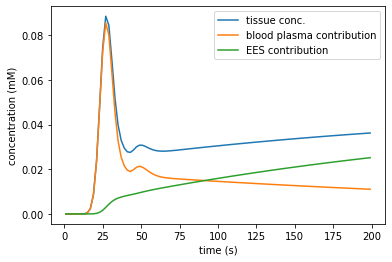

In [14]:
import aifs, pk_models
# define timepoints at which we want to calculate concentration
# assume an acquisition of 100 volumes, each taking 2s to acquire, starting at t=0 with linear phase encoding
# the time points are therefore t = 1, 3, ..., 199 s
dt = 2.
t = np.arange(0,100)*dt + dt/2

# create an AIF, with contrast injected at t = 15s
aif = aifs.parker(hct=0.42, t_start=15.)

# create the pharmacokinetic model object (2-compartment exchange model) with fixed (zero) AIF delay
pk_model = pk_models.tcxm(t, aif, upsample_factor=1, fixed_delay=0)

# specify some model parameters and calculate the total and compartmental concentrations
pk_pars = {'vp': 0.01, 'ps': 5e-3, 've': 0.2, 'fp': 20}
C_t, C_cp, C_e = pk_model.conc(**pk_pars)

plt.plot(t, C_t, '-', label='tissue conc.')
plt.plot(t, C_cp, '-', label='blood plasma contribution')
plt.plot(t, C_e, '-', label='EES contribution')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('concentration (mM)');

##### Parameters can be in  dict (for readability) or array format (for optimisation algorithms):

In [4]:
pk_pars_array = pk_model.pkp_array(pk_pars)
pk_pars_dict = pk_model.pkp_dict(pk_pars_array)
print(f"Parameters as array: {pk_pars_array}")
print(f"Parameters as dict: {pk_pars_dict}")

Parameters as array: [1.e-02 5.e-03 2.e-01 2.e+01]
Parameters as dict: {'vp': 0.01, 'ps': 0.005, 've': 0.2, 'fp': 20.0}


##### Required parameters have typical values (for scaling and as default initial estimates) and bounds...

In [5]:
print(f"Parameter names for this model are: {pk_model.parameter_names}")
print(f"Typical values for these parameters are: {pk_model.typical_vals}")
print(f"Bounds for these parameters are: {pk_model.bounds}")

Parameter names for this model are: ('vp', 'ps', 've', 'fp')
Typical values for these parameters are: [ 0.1   0.05  0.5  50.  ]
Bounds for these parameters are: ((1e-08, -0.001, 1e-08, 1e-08), (1, 1, 1, 200))


##### The irf method returns the impulse response functions for the plasma and EES compartments:

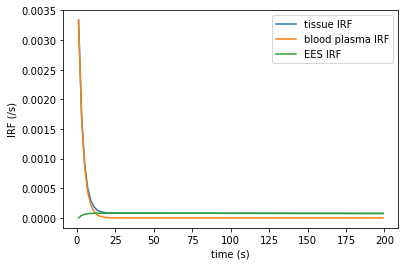

In [7]:
irf_cp, irf_ees = pk_model.irf(**pk_pars)
irf_tissue = irf_cp + irf_ees

plt.plot(pk_model.t_upsample, irf_tissue, '-', label='tissue IRF')
plt.plot(pk_model.t_upsample, irf_cp, '-', label='blood plasma IRF')
plt.plot(pk_model.t_upsample, irf_ees, '-', label='EES IRF')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('IRF (/s)');

##### Compare models...

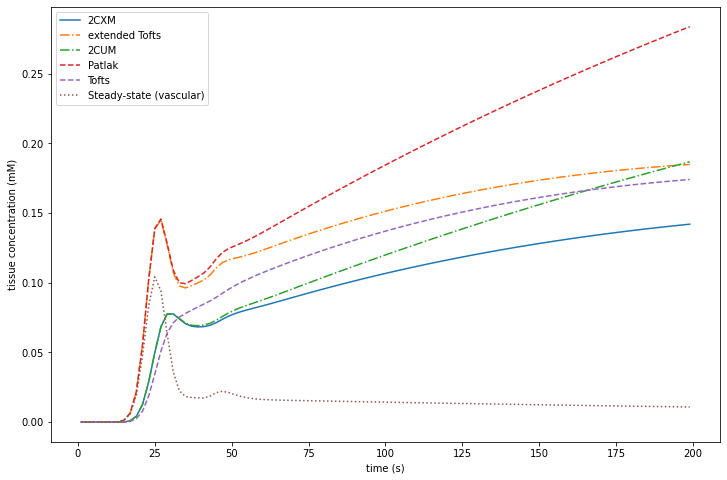

In [80]:
pk_model_tcxm = pk_models.tcxm(t, aif, upsample_factor=1000, fixed_delay=0)
pk_model_etofts = pk_models.extended_tofts(t, aif, upsample_factor=1000, fixed_delay=0)
pk_model_tcum = pk_models.tcum(t, aif, upsample_factor=1000, fixed_delay=0)
pk_model_patlak = pk_models.patlak(t, aif, upsample_factor=1000, fixed_delay=0)
pk_model_tofts = pk_models.tofts(t, aif, upsample_factor=1000, fixed_delay=0)
pk_model_steady_state = pk_models.steady_state_vp(t, aif, upsample_factor=1000, fixed_delay=0)

pk_pars = {'vp': 0.01, 'ps': 5e-2, 've': 0.2, 'fp': 10, 'ktrans': 5e-2}
#pk_pars = {'vp': 0.0001, 'ps': 5e-2, 've': 0.5, 'fp': 1000, 'ktrans': 5e-2}

C_t_tcxm, _C_cp, _C_e = pk_model_tcxm.conc(**pk_pars)
C_t_etofts, _C_cp, _C_e = pk_model_etofts.conc(**pk_pars)
C_t_tcum, _C_cp, _C_e = pk_model_tcum.conc(**pk_pars)
C_t_patlak, _C_cp, _C_e = pk_model_patlak.conc(**pk_pars)
C_t_tofts, _C_cp, _C_e = pk_model_tofts.conc(**pk_pars)
C_t_steady_state, _C_cp, _C_e = pk_model_steady_state.conc(**pk_pars)

plt.figure(0, figsize=(12,8))
plt.plot(t, C_t_tcxm, '-', label='2CXM')
plt.plot(t, C_t_etofts, '-.', label='extended Tofts')
plt.plot(t, C_t_tcum, '-.', label='2CUM')
plt.plot(t, C_t_patlak, '--', label='Patlak')
plt.plot(t, C_t_tofts, '--', label='Tofts')
plt.plot(t, C_t_steady_state, ':', label='Steady-state (vascular)')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('tissue concentration (mM)');